In [ ]:
!nvidia-smi

In [ ]:
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

In [52]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import unicodedata
import numpy as np
import pandas as pd
pd.options.display.max_columns = 50
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from collections import Counter
import ast
import random
import json
from math import isnan


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [45]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# New Section

In [ ]:
# sns.countplot(df.label_norm)
# plt.xlabel('review score');

In [2]:
from transformers import BertTokenizer,BertModel
PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext-large"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-bert-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
# PRE_TRAINED_MODEL_NAME = "ProsusAI/finbert"
# PRE_TRAINED_MODEL_NAME = "bert-base-chinese"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True)

In [3]:
PRE_TRAINED_MODEL_NAME = "/home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model"


In [4]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }
    

In [69]:
import ast

df_train = pd.read_csv('../data/pre/train.csv',sep='\t')
df_val = pd.read_csv('../data/pre/val.csv',sep='\t')
df_test = pd.read_csv('../data/pre/test.csv',sep='\t')
df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_all = pd.read_csv('../data/df_all_year_srl.csv',sep='\t')

df_train = df_train.drop(df_train.loc[df_train.verbA0A1.isna()].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1.isna()].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)

df_train = df_train.drop(df_train.loc[df_train.verbA0A1=='[]'].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1=='[]'].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1=='[]'].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)


In [70]:
[col for col in df_all.columns.tolist() if col not in df_train.columns.tolist()]
[col for col in df_train.columns.tolist() if col not in df_all.columns.tolist()]
df_train.head(1)

['open_close_chg', 'co_label', 'cc_label']

['TITLE']

,CODE,DATE,label,text_a,verb,A0,A1,verbA0A1,verb_mask,A0_mask,A1_mask,AV_num,trade_date,stock_factors,NAME,CREATED_DATE,TITLE,DESCRIPTION,READ,MARKET,CHANGE,FIRST_DAY,SECOND_DAY,original_price,open1,close1,day1,open2,close2,day2,open3,close3,day3,open4,close4,day4,open5,close5,day5
0,2092,2020-10-27 20:02:00,0,中泰化学披露三季报，公司2020年前三季度营业收入649.7亿元，同比增长0.71%；净利润...,"[(4, 2), (31, 2), (41, 2), (58, 1), (74, 1)]","[(0, 2), (2, 2), (49, 2), (51, 2), (53, 1), (5...","[(38, 3), (6, 3), (33, 4), (59, 2), (61, 4), (...","[[[(4, 2)], [(0, 2), (2, 2)], [(6, 3)]], [[(58...",[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,[[0. 0.25 0.25 ... 0. 0. 0. ]\n [0. 0...,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,3,2020-10-27,"[-0.381438783485548, -0.3849424060242681, -0.3...",中泰化学,2020-10-27 20:02:00,中泰化学披露三季报，公司2020年前三季度营业收入649.7亿元，同比增长0.71%；净利润...,中泰化学披露三季报，公司2020年前三季度营业收入649.7亿元，同比增长0.71%；净利润...,5870280.0,0.0,-0.021318,2020-10-27,2020-10-28,5.0455,5.0855,5.1754,2020-10-29,5.1854,5.0955,2020-10-30,5.0955,5.0455,2020-11-02,5.0855,5.1854,2020-11-03,5.1654,5.1554,2020-11-04


In [71]:
def string_to_tuples_list(text):
  if text is np.nan or text =='[]':
    return []
  text = ''.join(text.split('], ['))
  tmp = eval(text.strip('[').strip(']'))
  if not isinstance(tmp[0],tuple):
    return [tmp]
  return list(tmp)

In [72]:
for col in ['verb','A0','A1']:
    df_train[col] = df_train[col].apply(string_to_tuples_list)
    df_val[col] = df_val[col].apply(string_to_tuples_list)
    df_test[col] = df_test[col].apply(string_to_tuples_list)
    df_ood[col] = df_ood[col].apply(string_to_tuples_list)
for col in ['stock_factors','verbA0A1']:
    df_train[col] = df_train[col].apply(ast.literal_eval)
    df_val[col] = df_val[col].apply(ast.literal_eval)
    df_test[col] = df_test[col].apply(ast.literal_eval)
    df_ood[col] = df_ood[col].apply(ast.literal_eval)

In [ ]:
idx = []

for v in df_train.loc[131, 'verbA0A1'][0][2]:
    idx = idx + [int(i) for i in range(v[0],v[0]+v[1])]
counter = Counter(idx)
idx
counter
mask = np.zeros(299)
mask = [0 if counter[i] == 0 else 1/len(counter) for i in range(0, len(mask))]
mask.insert(0,0)
mask

In [104]:
def mask(df):
  df = df.reset_index(drop = True)
  df['verb_mask'] = 0
  df['A0_mask'] = 0
  df['A1_mask'] = 0
  df['verb_mask'] = df['verb_mask'].astype('object')
  df['A0_mask'] = df['A0_mask'].astype('object')
  df['A1_mask'] = df['A1_mask'].astype('object')
  for index, row in df.iterrows():

    df.at[index, 'stock_factors'] = [*map(float,df.loc[index,'stock_factors'])]  # change data type to float
    AV_num = 0
    for k, col in enumerate(['verb','A0','A1']):
      masks = []
      for j in range(len(row['verbA0A1'])):
        mask = np.zeros(299)
        idx = []
        for v in row['verbA0A1'][j][k]:
          
          idx = idx + [int(i) for i in range(v[0],v[0]+v[1])]
        counter = Counter(idx)

        mask = [0 if counter[i]== 0 else 1/len(counter) for i in range(0, len(mask))]
        mask.insert(0,0)
        masks.append(mask)
      AV_num = len(masks)
      for i in range(10 - len(masks)):
        masks.append(np.zeros(300))
      while len(masks)>10:
        masks.pop()
      name = col+'_mask'
      df.at[index,name] = np.array(masks)
    if AV_num>10:
      AV_num=10
    df.loc[index,'AV_num'] = int(AV_num)
  df.AV_num = df.AV_num.astype('int')
#   df.stock_factors = df.stock_factors.apply(np.array)
  return df


df_train = mask(df_train)
df_test = mask(df_test)
df_val = mask(df_val)
df_ood = mask(df_ood)

In [120]:
max_len = 300
class_names = ['negative', 'neutral', 'positive']
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, verb, A0, A1, AV_num, tokenizer, stock_factors, max_len):
    self.reviews = reviews
    self.targets = targets
    self.stock_factors = stock_factors
    self.verb = verb
    self.A0 = A0
    self.A1 = A1
    self.AV_num = AV_num
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    stock_factors = self.stock_factors[item]
    v = self.verb[item]
    a0 = self.A0[item]
    a1 = self.A1[item]
    av_num = self.AV_num[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'stock_factors':torch.tensor(stock_factors),
      'verb': torch.tensor(v),
      'A0': torch.tensor(a0),
      'A1': torch.tensor(a1),
      'AV_num': torch.tensor(av_num)
    }

In [122]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text_a.to_numpy(),
    targets=df.label.to_numpy(),
    stock_factors = df.stock_factors,
    verb = df.verb_mask,
    A0 = df.A0_mask,
    A1 = df.A1_mask,
    AV_num = df.AV_num,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    # num_workers=4,
    shuffle=True
  )

In [9]:
# df_train.sample(n=4000).to_csv('/content/drive/MyDrive/data/df_train_srl.csv',sep='\t',index=None)
# df_test.sample(n=500).to_csv('/content/drive/MyDrive/data/df_test_srl.csv',sep='\t',index=None)
# df_val.sample(n=500).to_csv('/content/drive/MyDrive/data/df_val_srl.csv',sep='\t',index=None)

In [123]:
BATCH_SIZE = 16


df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_ood = df_ood.reset_index(drop=True)



train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

### 資料集
- `stock_factors` 會隨公司和交易日改變（同交易日則相同），計算方式或資料元？
- 應該是盤前、盤中為預測當日；盤後則預測隔日；但有些時間點拼得很奇怪，從 pre/ 資料夾裡的內容怎麼生成出來的沒給程式


In [155]:
# df_train[(df_train["label"]==1)].sort_values("CREATED_DATE")#&(df_train["NAME"]=="中国银行")&(df_train["trade_date"]=="2020-02-26")]
# df_train.NAME.value_counts()
# import datetime as dt
# df_train["hour"] = df_train["CREATED_DATE"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour)
# df_train[df_train["hour"]==12]


In [156]:
class SentimentClassifier(nn.Module):
  """以股價變化比率的級距劃分 3 種 label 作為訓練目標，訓練出以前日新聞預測當日股價變化級距的分類模型 (不完全是傳統的 sentiment classifier)
  """
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, output_attentions=True)
    self.drop = nn.Dropout(p=0.1)
    self.sig = nn.Sigmoid()
    # self.relu = nn.ReLU()
    # self.L1 = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size//2)
    self.out1 = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[1]

#     print(result.keys())

#     attention_weight = torch.sum(result.attentions[11][:,:,:,:],1)[:,0,:]
#     print(pooled_output.keys())

#     output = torch.mean(pooled_output,1)
#     output = self.drop(pooled_output)
    # # output = self.L1(output)
#     output = self.out(output)
#     output = self.flatten(transformer_output.float())
    output = self.sig(pooled_output)
#     output = self.drop(output)
    output = self.out1(output)
    output = self.sig(output)
    output = self.drop(output)
    output = self.out(output)
 
    return output

In [157]:
model = SentimentClassifier(3)
model = model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at /home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [158]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets', 'stock_factors', 'verb', 'A0', 'A1', 'AV_num'])

In [20]:
data["review_text"][0]

'航天发展披露三季报，前三季度归属于母公司所有者的净利润4.18亿元，同比增长35.79%；营业收入28.78亿元，同比增长22.37%；基本每股收益0.26元，同比增长36.84%。'

In [159]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 300])
torch.Size([16, 300])


In [160]:
output = model(input_ids, attention_mask)

# output.attentions[0][0].shape

# len(output.attentions)

# output.attentions[0][:,:,:,:]

# torch.sum(output.attentions[0][:,:,:,:],1)[:,1,:]

# output.attentions[0]

# F.softmax(output[0], dim=1)

In [167]:
output

tensor([[-0.2125,  0.5468, -0.0376],
        [-0.4980,  0.6701, -0.1294],
        [-0.4079,  0.5452, -0.0966],
        [-0.5304,  0.7526, -0.1457],
        [-0.4213,  0.6326, -0.1375],
        [-0.3714,  0.5503,  0.0646],
        [-0.3837,  0.6156,  0.0279],
        [-0.6243,  0.6973, -0.0605],
        [-0.3606,  0.8182,  0.0390],
        [-0.3434,  0.5296, -0.1672],
        [-0.4142,  0.5810, -0.1959],
        [-0.4156,  0.5713, -0.2396],
        [-0.4587,  0.6533,  0.0136],
        [-0.3426,  0.6297, -0.2227],
        [-0.3379,  0.7378, -0.2048],
        [-0.4067,  0.6063, -0.0660]], device='cuda:0', grad_fn=<AddmmBackward>)

In [169]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [24]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
history = defaultdict(list)
best_accuracy = 0
# EPOCHS = 5

In [27]:
%%time

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Pretrained_RoBERT.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.9556163629272472 accuracy 0.5467625899280575
Val   loss 0.8882167473916085 accuracy 0.6012186865267434

Epoch 2/10
----------
Train loss 0.8308756541415384 accuracy 0.6453660600931019
Val   loss 0.8539726112478523 accuracy 0.6208530805687204

Epoch 3/10
----------
Train loss 0.7453443644737198 accuracy 0.6986881083368599
Val   loss 0.8618297516017832 accuracy 0.6316858496953284

Epoch 4/10
----------
Train loss 0.6720798548527758 accuracy 0.7452391028353788
Val   loss 0.8770431097476713 accuracy 0.6323628977657414

Epoch 5/10
----------
Train loss 0.586863697321231 accuracy 0.792044011849344
Val   loss 0.9269211266630439 accuracy 0.6255924170616114

Epoch 6/10
----------
Train loss 0.5130514997348734 accuracy 0.8293694456199746
Val   loss 1.0053555215558698 accuracy 0.6208530805687204

Epoch 7/10
----------
Train loss 0.45785047722846794 accuracy 0.8555226407109606
Val   loss 1.0482245202987426 accuracy 0.6194989844278943

Epoch 8/10
----------
Train 

In [28]:
len(history["train_acc"])

10

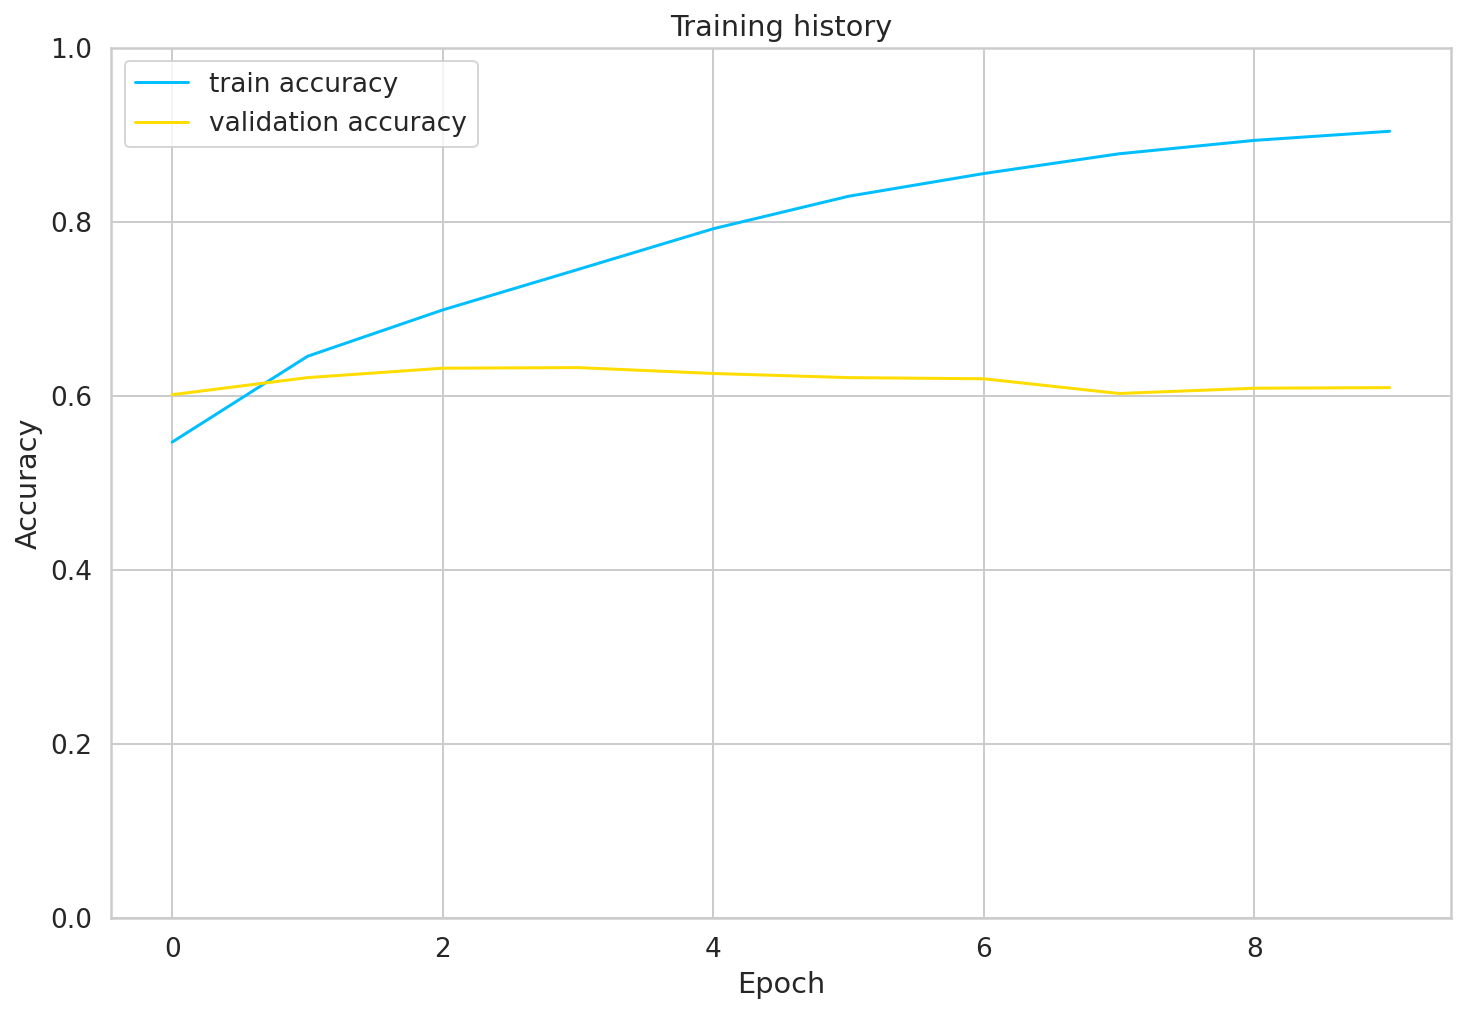

In [29]:
plt.plot([i.cpu() for i in history['train_acc']], label='train accuracy')
plt.plot([i.cpu() for i in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [30]:
class_names={'negative','neutral','positive'}

In [31]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('Pretrained_RoBERT.bin'))
model = model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at /home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
len(df_test)

1477

In [33]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6283006093432634

In [ ]:
# text=df_test.loc[df_test.text_a.apply(len)<100].sample(n=1).text_a.values[0]

# text_final = ''
# for i in tokenizer.tokenize(text):
#     tem = ' '+i
#     text_final+=tem

# text_final = text_final[1:]



# #Credits to Lin Zhouhan(@hantek) for the complete visualization code
# import random, os, numpy, scipy
# from codecs import open
# def createHTML(texts, weights, fileName):
#     """
#     Creates a html file with text heat.
# weights: attention weights for visualizing
# texts: text on which attention weights are to be visualized
#     """
#     fileName = "./visualization/"+fileName
#     fOut = open(fileName, "w", encoding="utf-8")
#     part1 = """
#     <html lang="zh-Hans">
#     <head>
#     <meta http-equiv="content-type" content="text/html; charset=utf-8">
#     <style>
#     body {
#     font-family: Sans-Serif;
#     }
#     </style>
#     </head>
#     <body>
#     <h3>
#     Heatmaps
#     </h3>
#     </body>
#     <script>
#     """
#     part2 = """
#     var color = "255,0,0";
#     var ngram_length = 3;
#     var half_ngram = 1;
#     for (var k=0; k < any_text.length; k++) {
#     var tokens = any_text[k].split(" ");
#     var intensity = new Array(tokens.length);
#     var max_intensity = Number.MIN_SAFE_INTEGER;
#     var min_intensity = Number.MAX_SAFE_INTEGER;
#     for (var i = 0; i < intensity.length; i++) {
#     intensity[i] = 0.0;
#     for (var j = -half_ngram; j < ngram_length-half_ngram; j++) {
#     if (i+j < intensity.length && i+j > -1) {
#     intensity[i] += trigram_weights[k][i + j];
#     }
#     }
#     if (i == 0 || i == intensity.length-1) {
#     intensity[i] /= 2.0;
#     } else {
#     intensity[i] /= 3.0;
#     }
#     if (intensity[i] > max_intensity) {
#     max_intensity = intensity[i];
#     }
#     if (intensity[i] < min_intensity) {
#     min_intensity = intensity[i];
#     }
#     }
#     var denominator = max_intensity - min_intensity;
#     for (var i = 0; i < intensity.length; i++) {
#     intensity[i] = (intensity[i] - min_intensity) / denominator;
#     }
#     if (k%2 == 0) {
#     var heat_text = "<p><br><b>Example:</b><br>";
#     } else {
#     var heat_text = "<b>Example:</b><br>";
#     }
#     var space = " ";
#     for (var i = 0; i < tokens.length; i++) {
#     heat_text += "<span style='background-color:rgba(" + color + "," + intensity[i] + ")'>"  + tokens[i] + "</span>";
#     if (space == "") {
#     space = " ";
#     }
#     }
#     //heat_text += "<p>";
#     document.body.innerHTML += heat_text;
#     }
#     </script>
#     </html>"""
#     putQuote = lambda x: "\"%s\""%x
#     textsString = "var any_text = [%s];\n"%(",".join(map(putQuote, texts)))
#     weightsString = "var trigram_weights = [%s];\n"%(",".join(map(str,weights)))
# #     print(part1)
# #     print(textsString)
# #     print(part2)
# #     print(weightsString)
#     fOut.write(part1)
#     fOut.write(textsString)
#     fOut.write(weightsString)
#     fOut.write(part2)
#     fOut.close()
  
#     return
# # ===================================================
# # 2. add text and get weight
# # ===================================================
# text1 = text_final
# tok = tokenizer.tokenize(text1)
# # text2 = 'NEWS'
# # p_pos = len(tok1)
# # tok2 = tokenizer.tokenize(text2)
# # tok = tok1+tok2


# ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cuda')

# with torch.no_grad():
#     output = model.bert(ids)
# attentions = torch.cat(output[2]).to('cpu')

# # =================================================
# # 3. creat html attention heat map
# # =================================================
# createHTML([text1],[attentions[11,3,0,1:-2].numpy().tolist()],'Pretrained_RoBERT.html')


In [34]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [35]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

              precision    recall  f1-score   support

    positive     0.6876    0.6322    0.6588       484
    negative     0.5869    0.6020    0.5943       505
     neutral     0.6187    0.6516    0.6347       488

    accuracy                         0.6283      1477
   macro avg     0.6311    0.6286    0.6293      1477
weighted avg     0.6304    0.6283    0.6288      1477



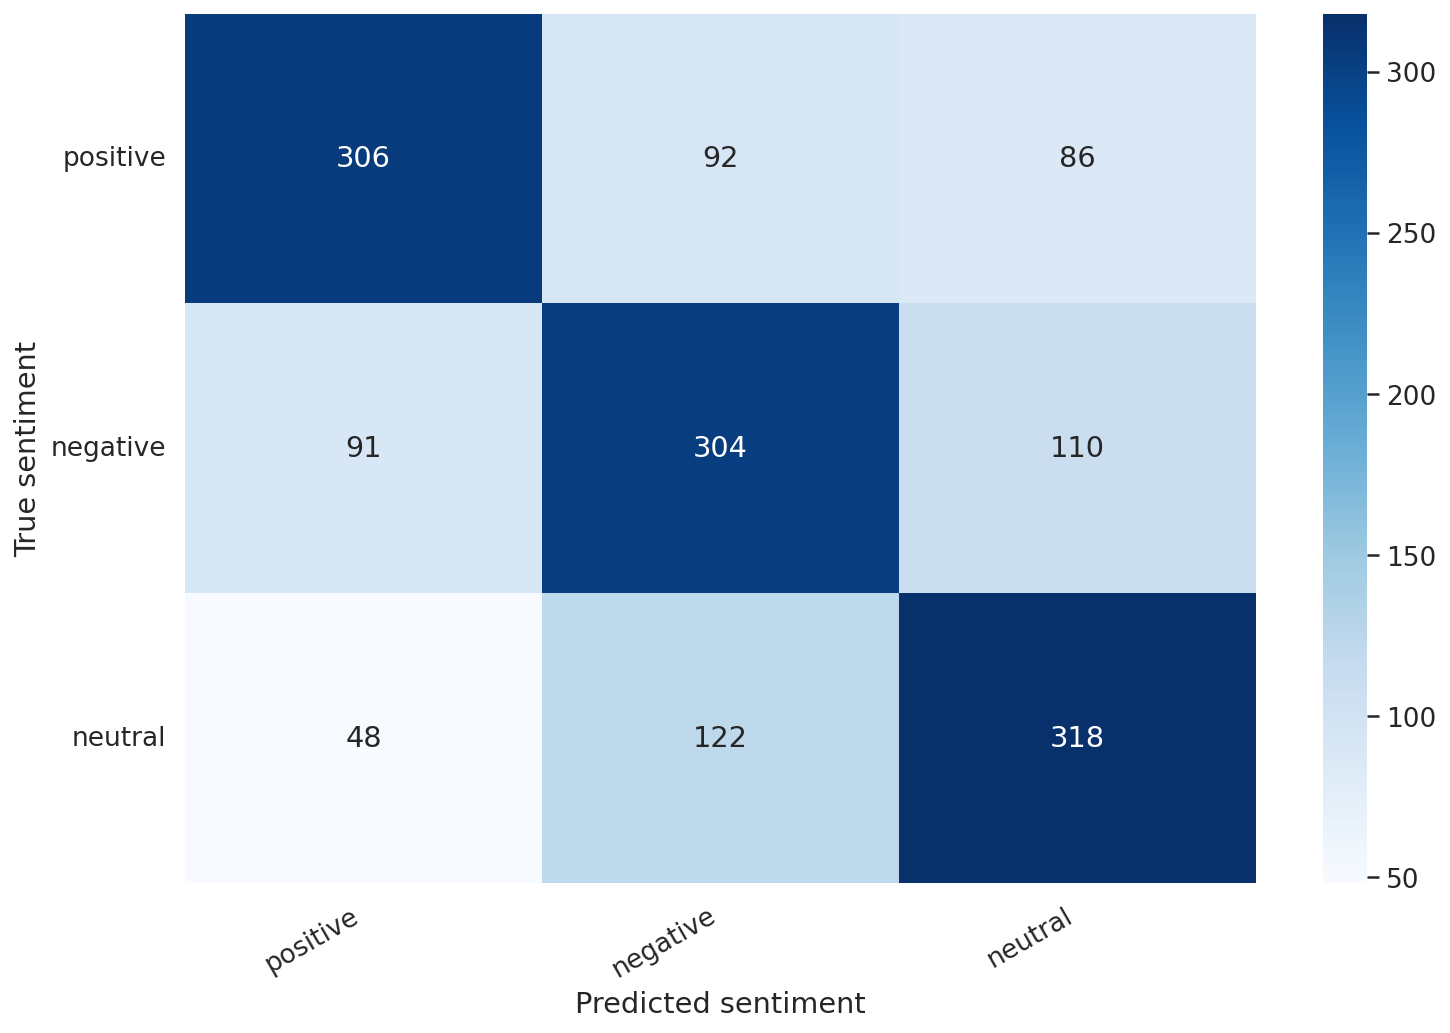

In [36]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names,digits = 4))


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

    positive     0.6449    0.5717    0.6061      3133
    negative     0.5747    0.5752    0.5749      3406
     neutral     0.6046    0.6636    0.6328      3618

    accuracy                         0.6056     10157
   macro avg     0.6081    0.6035    0.6046     10157
weighted avg     0.6070    0.6056    0.6051     10157



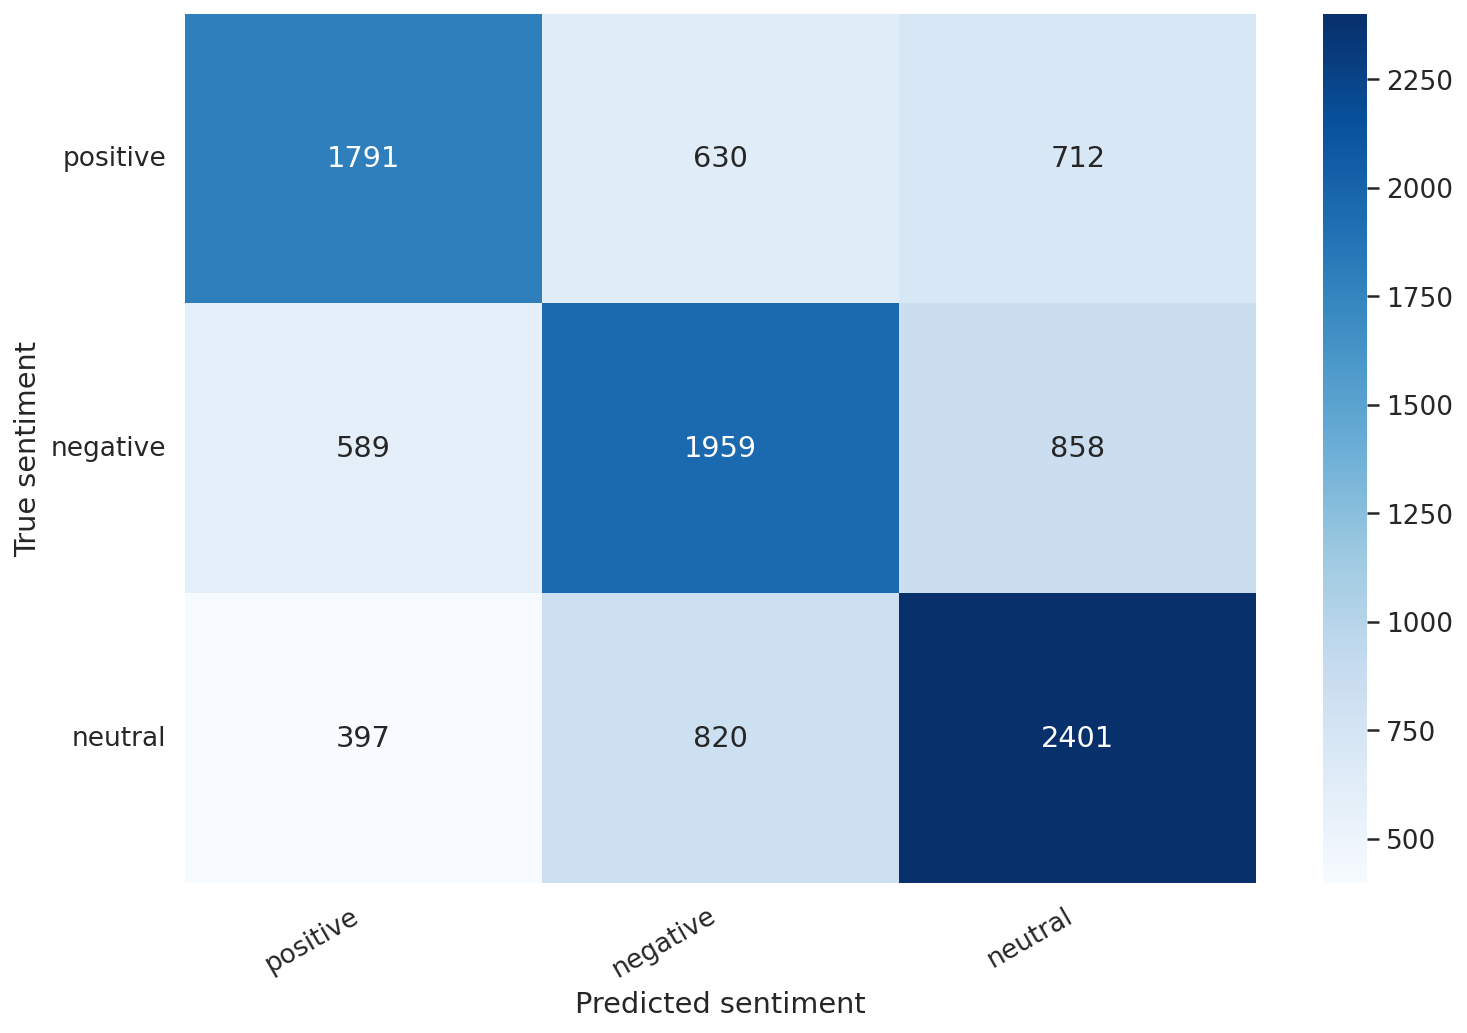

In [37]:
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

              precision    recall  f1-score   support

    positive     0.6593    0.5705    0.6117       943
    negative     0.5484    0.5708    0.5594       953
     neutral     0.6417    0.6842    0.6623      1330

    accuracy                         0.6175      3226
   macro avg     0.6165    0.6085    0.6111      3226
weighted avg     0.6193    0.6175    0.6171      3226



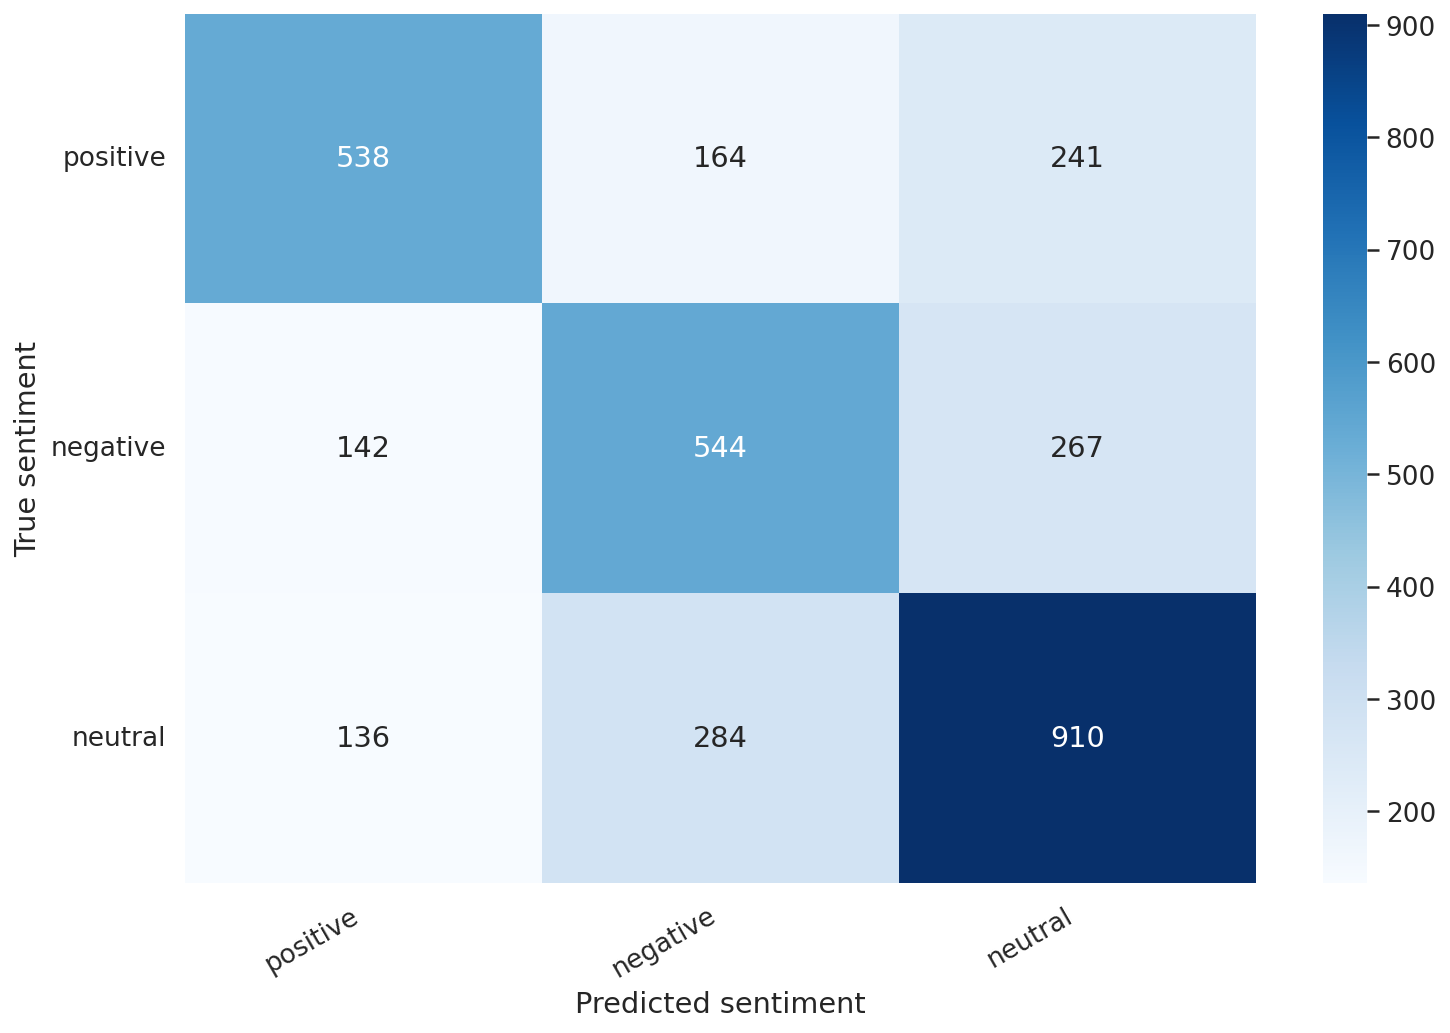

              precision    recall  f1-score   support

    positive     0.6637    0.6051    0.6331       623
    negative     0.6675    0.6158    0.6406       825
     neutral     0.6125    0.7045    0.6553       792

    accuracy                         0.6442      2240
   macro avg     0.6479    0.6418    0.6430      2240
weighted avg     0.6470    0.6442    0.6437      2240



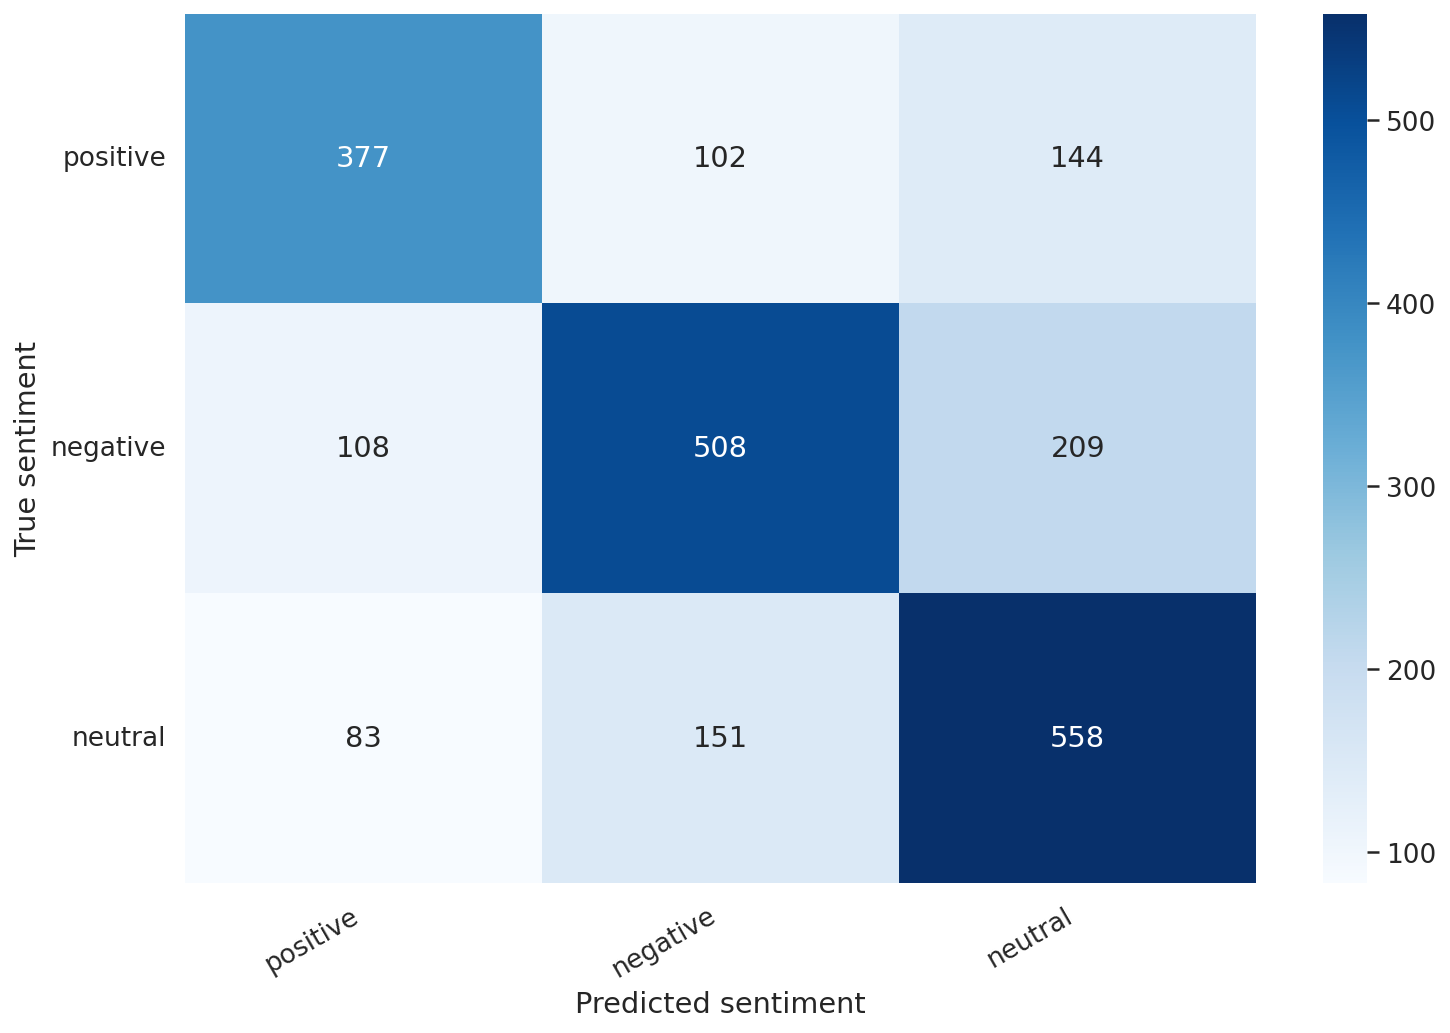

              precision    recall  f1-score   support

    positive     0.6373    0.5618    0.5972      1157
    negative     0.5462    0.5466    0.5464      1169
     neutral     0.5603    0.6300    0.5931      1092

    accuracy                         0.5784      3418
   macro avg     0.5812    0.5795    0.5789      3418
weighted avg     0.5815    0.5784    0.5785      3418



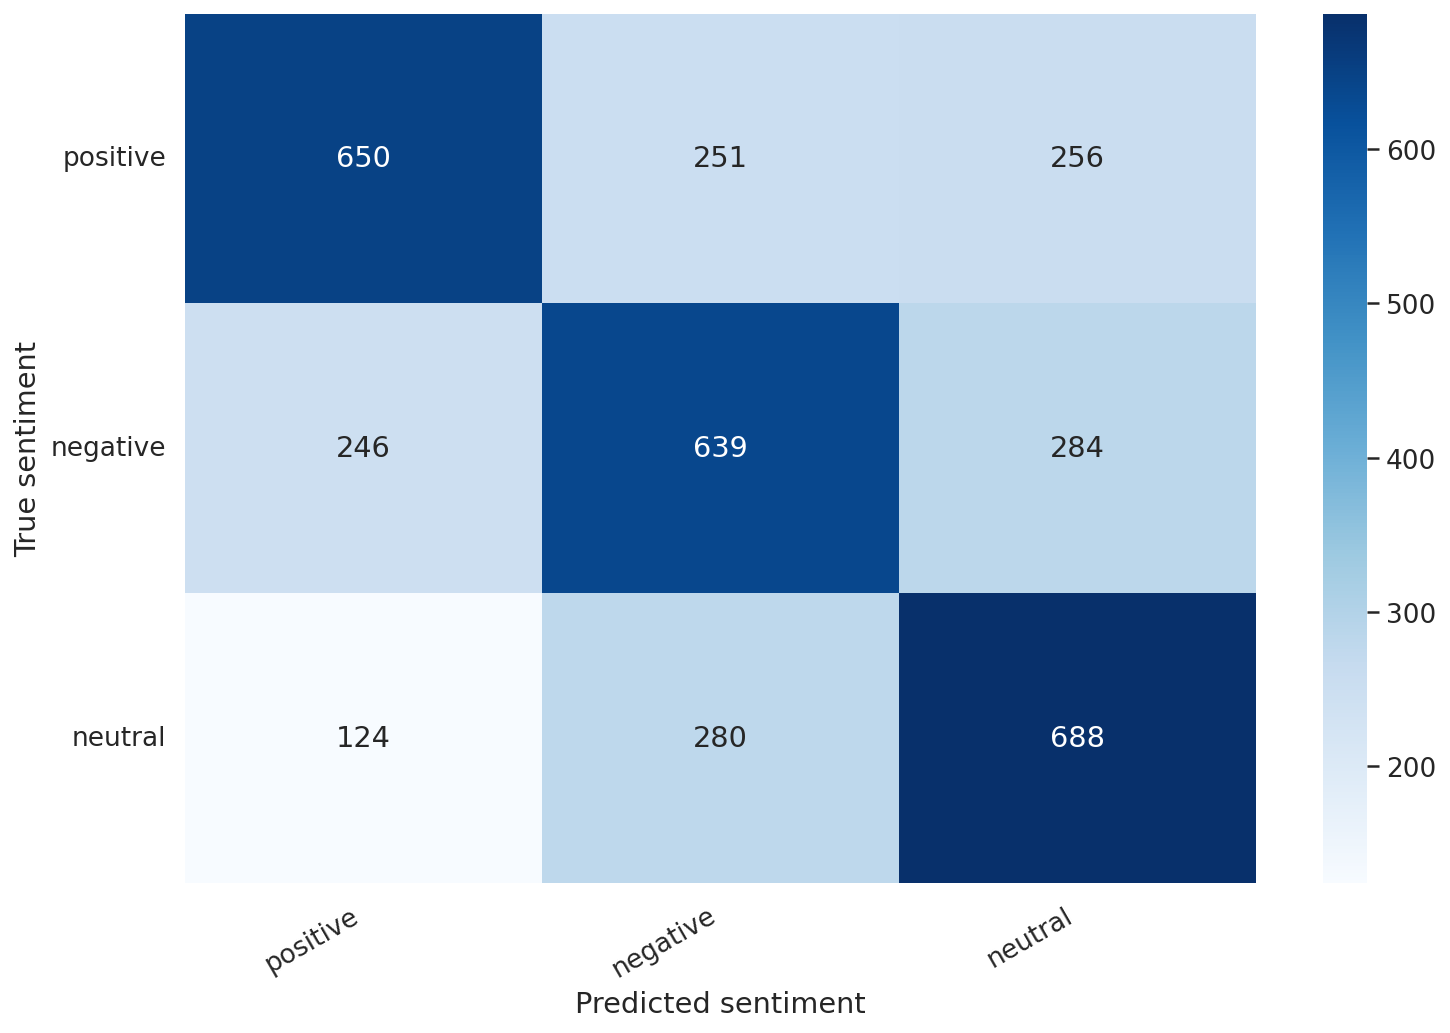

              precision    recall  f1-score   support

    positive     0.6066    0.5495    0.5766       404
    negative     0.5511    0.5794    0.5649       447
     neutral     0.5808    0.6037    0.5920       381

    accuracy                         0.5771      1232
   macro avg     0.5795    0.5775    0.5778      1232
weighted avg     0.5785    0.5771    0.5771      1232



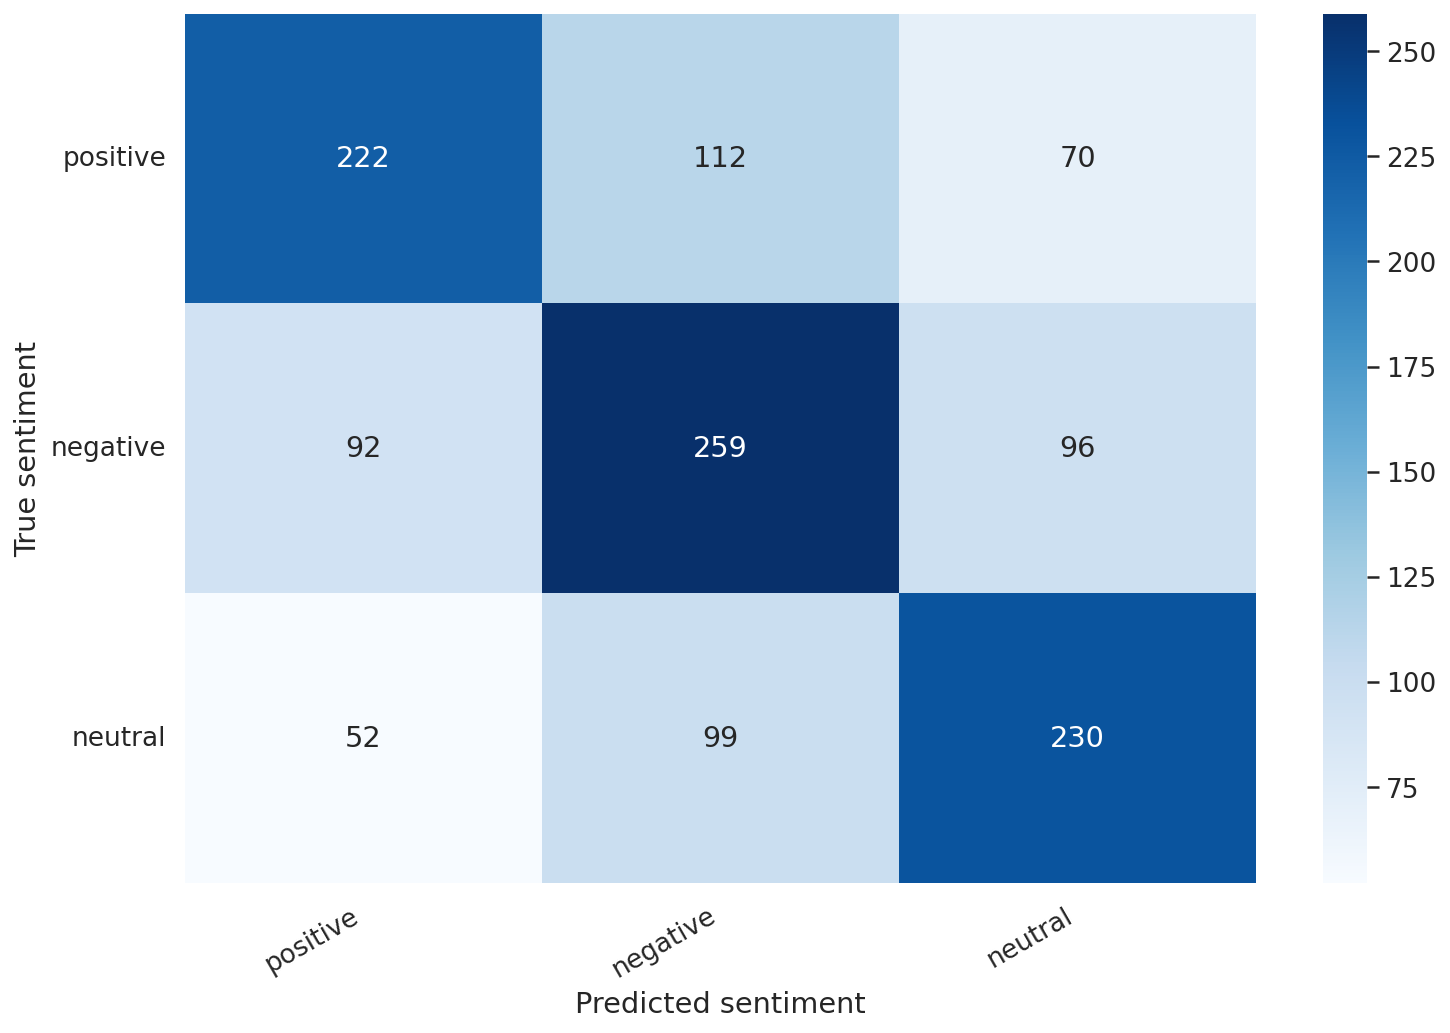

In [38]:
df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-01-01')&(df_ood.DATE<='2021-03-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-04-01')&(df_ood.DATE<='2021-06-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-07-01')&(df_ood.DATE<='2021-09-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[df_ood.DATE>='2021-10-01']
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

/home/jovyan/conda_env/bert_try/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/conda_env/bert_try/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/conda_env/bert_try/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    positive     0.0000    0.0000    0.0000         0
    negative     1.0000    0.3833    0.5542     16798
     neutral     0.0000    0.0000    0.0000         0

    accuracy                         0.3833     16798
   macro avg     0.3333    0.1278    0.1847     16798
weighted avg     1.0000    0.3833    0.5542     16798



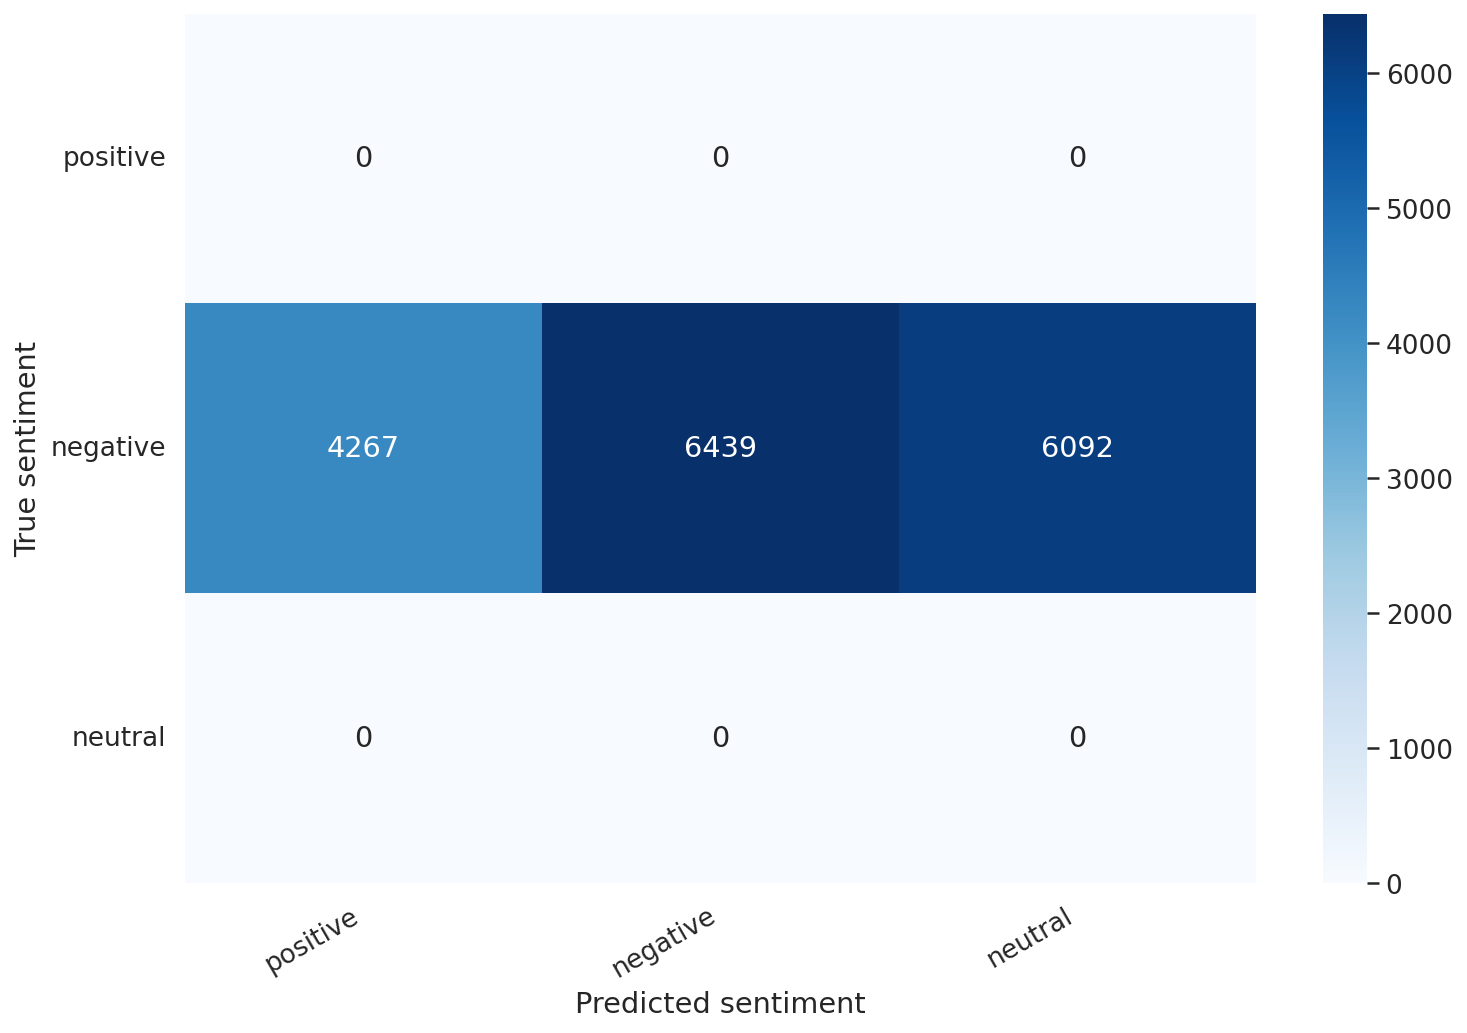

In [39]:
df_ood = pd.read_csv('../data/df_all_year_srl.csv',sep='\t')
# df_ood = df_ood.loc[(df_ood.DATE>='2021-05-05')&(df_ood.DATE<='2021-09-01')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

In [40]:
df = pd.DataFrame([y_ood_review_texts, y_ood_pred.numpy(), y_ood_pred_probs.numpy(), y_ood.numpy()]).T
df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
df.to_csv('Pretrained_RoBERT_ood.csv',sep='\t')

In [41]:
attentions.shape

NameError: name 'attentions' is not defined

In [ ]:
# !pip install lit-nlp

In [ ]:
# from lit_nlp.api.dataset import Dataset
# class MultiNLIData(Dataset):
#   """Loader for MultiNLI development set."""
#   def __init__(self, df):
#     # Read the eval set from a .tsv file as distributed with the GLUE benchmark.
#     # df = pandas.read_csv(path, sep='\t')
#     # Store as a list of dicts, conforming to self.spec()
#     self.LABELS = [0,1]
#     self._examples = [{
#       'sentence': row['DESCRIPTION_EN'],
#       # 'hypothesis': row['sentence2'],
#       'label': row['LABEL']
#       # 'genre': row['genre'],
#     } for _, row in df.iterrows()]
#   def spec(self):
#     return {
#       'sentence': lit_types.TextSegment(),
#       # 'hypothesis': lit_types.TextSegment(),
#       'label': lit_types.CategoryLabel(vocab=self.LABELS),
#       # We can include additional fields, which don't have to be used by the model.
#       # 'genre': lit_types.Label(),
#     }

In [ ]:
# from absl import app
# from absl import flags
# from absl import logging

# from lit_nlp import dev_server
# from lit_nlp import server_flags
# from lit_nlp.api import model as lit_model
# from lit_nlp.api import types as lit_types
# # Use the regular GLUE data loaders, because these are very simple already.
# from lit_nlp.examples.datasets import glue
# from lit_nlp.lib import utils

# import torch
# import transformers

# # NOTE: additional flags defined in server_flags.py

# FLAGS = flags.FLAGS

# flags.DEFINE_string(
#     "model_path",
#     "https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz",
#     "Path to trained model, in standard transformers format, e.g. as "
#     "saved by model.save_pretrained() and tokenizer.save_pretrained()")


# def _from_pretrained(cls, *args, **kw):
#   """Load a transformers model in PyTorch, with fallback to TF2/Keras weights."""
#   try:
#     return cls.from_pretrained(*args, **kw)
#   except OSError as e:
#     logging.warning("Caught OSError loading model: %s", e)
#     logging.warning(
#         "Re-trying to convert from TensorFlow checkpoint (from_tf=True)")
#     return cls.from_pretrained(*args, from_tf=True, **kw)


# class SimpleSentimentModel(lit_model.Model):
#   """Simple sentiment analysis model."""

#   LABELS = [0,1]  # negative, positive

#   def __init__(self, model_name_or_path):
#     self.tokenizer = transformers.AutoTokenizer.from_pretrained(
#         model_name_or_path)
#     model_config = transformers.AutoConfig.from_pretrained(
#         model_name_or_path,
#         num_labels=2,
#         output_hidden_states=True,
#         output_attentions=True,
#     )
#     # This is a just a regular PyTorch model.
#     self.model = _from_pretrained(
#         transformers.AutoModelForSequenceClassification,
#         model_name_or_path,
#         config=model_config)
#     self.model.eval()

#   ##
#   # LIT API implementation
#   def max_minibatch_size(self):
#     # This tells lit_model.Model.predict() how to batch inputs to
#     # predict_minibatch().
#     # Alternately, you can just override predict() and handle batching yourself.
#     return 16

#   def predict_minibatch(self, inputs):
#     # Preprocess to ids and masks, and make the input batch.
#     encoded_input = self.tokenizer.batch_encode_plus(
#         [ex["sentence"] for ex in inputs],
#         return_tensors="pt",
#         add_special_tokens=True,
#         max_length=200,
#         padding="longest",
#         truncation="longest_first")

#     # Check and send to cuda (GPU) if available
#     if torch.cuda.is_available():
#       self.model.cuda()
#       for tensor in encoded_input:
#         encoded_input[tensor] = encoded_input[tensor].cuda()
#     # Run a forward pass.
#     with torch.no_grad():  # remove this if you need gradients.
#       out: transformers.modeling_outputs.SequenceClassifierOutput = \
#           self.model(**encoded_input)

#     # Post-process outputs.
#     batched_outputs = {
#         "probas": torch.nn.functional.softmax(out.logits, dim=-1),
#         "input_ids": encoded_input["input_ids"],
#         "ntok": torch.sum(encoded_input["attention_mask"], dim=1),
#         "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
#     }
#     # Return as NumPy for further processing.
#     detached_outputs = {k: v.cpu().numpy() for k, v in batched_outputs.items()}
#     # Unbatch outputs so we get one record per input example.
#     for output in utils.unbatch_preds(detached_outputs):
#       ntok = output.pop("ntok")
#       output["tokens"] = self.tokenizer.convert_ids_to_tokens(
#           output.pop("input_ids")[1:ntok - 1])
#       yield output

#   def input_spec(self) -> lit_types.Spec:
#     return {
#         "sentence": lit_types.TextSegment(),
#         "label": lit_types.CategoryLabel(vocab=self.LABELS, required=False)
#     }

#   def output_spec(self) -> lit_types.Spec:
#     return {
#         "tokens": lit_types.Tokens(),
#         "probas": lit_types.MulticlassPreds(parent="label", vocab=self.LABELS),
#         "cls_emb": lit_types.Embeddings()
#     }


In [ ]:
# dataset = MultiNLIData(df_train.sample(1800))

In [ ]:
# datasets = {"sst_dev": dataset}
# models = {"sst": SimpleSentimentModel("/content/drive/MyDrive/model/best_model/")}
# # models = {"sst": SimpleSentimentModel("bert-base-uncased")}

In [ ]:
# from lit_nlp import notebook
# widget = notebook.LitWidget(models, datasets, height=800)

In [ ]:
# mm = models["sst"]

In [ ]:
# mm.model.config

In [ ]:
# widget.render()

In [ ]:
# dataset.LABELS


In [ ]:
# df.loc[df.NAME=="三角防务"]